In [ ]:
# Load and Transform CIFAR-10 Dataset

from torchvision import datasets, transforms
import torch

# Define transformations for the training and testing sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Define a Custom CNN Model
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    

In [3]:
#Define Model,Loss Function and Optimize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import torch


# Training Function
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(5): # 10–20 epochs
    model.train()
    train_loss = 0
    correct = 0
    total = 0


    # Training
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(train_accuracy)


    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss_list.append(val_loss / len(test_loader))
    val_acc_list.append(val_accuracy)
       
    print(f'Epoch {epoch+1}: Train Loss = {train_loss:.3f}, Train Acc = {train_accuracy:.2f}%, Val Acc = {val_accuracy:.2f}%')


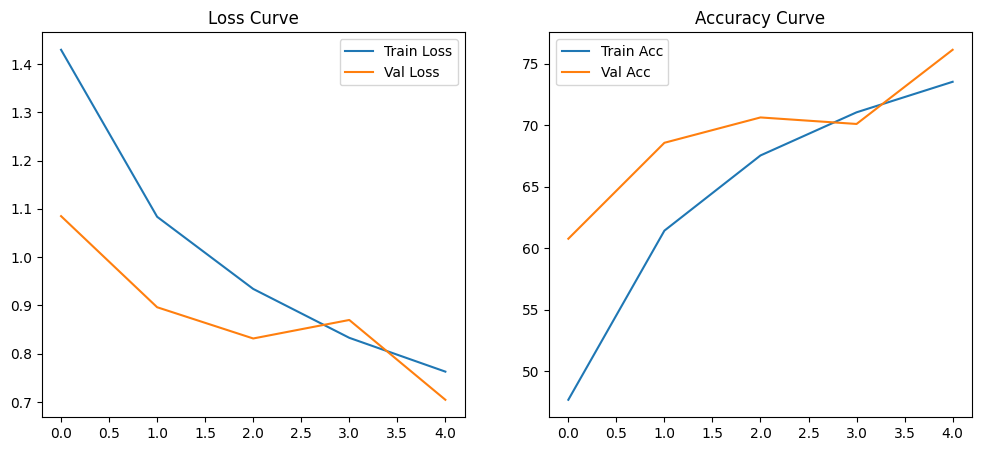

In [ ]:
# Loss and Accuracy Curve plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()


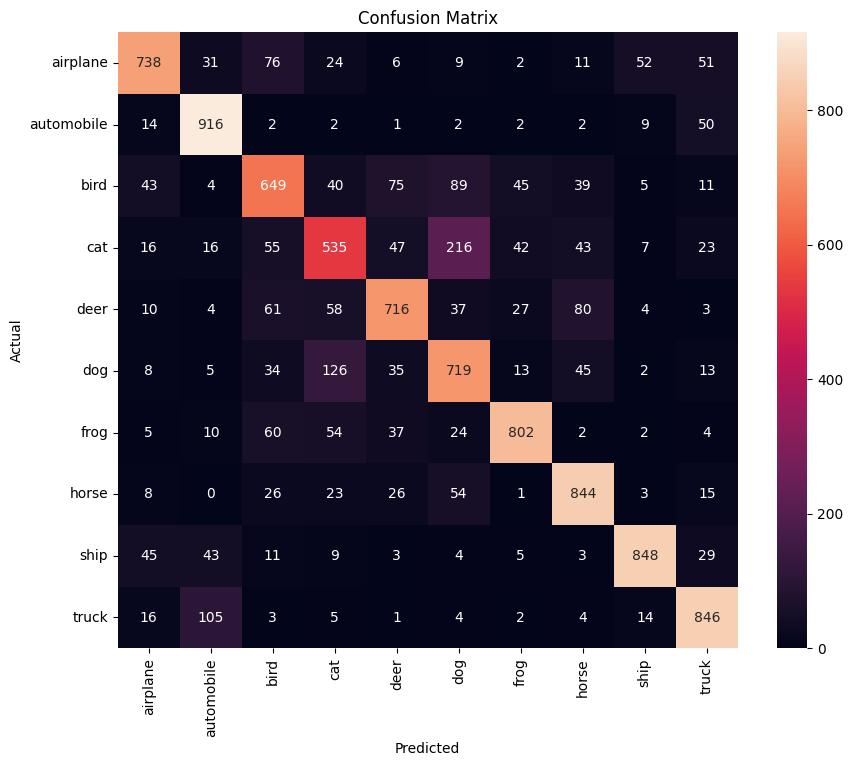

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Correct Predictions:


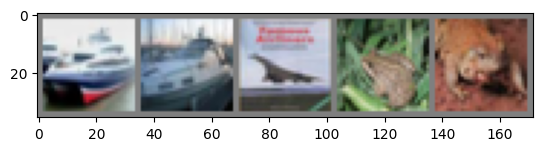

Incorrect Predictions:


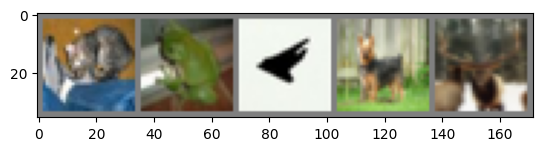

In [ ]:
import torchvision
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Show some correct predictions
correct_indices = [i for i in range(len(all_preds)) if all_preds[i] == all_labels[i]]
incorrect_indices = [i for i in range(len(all_preds)) if all_preds[i] != all_labels[i]]

print("Correct Predictions:")
imshow(torchvision.utils.make_grid(torch.stack([test_dataset[i][0] for i in correct_indices[:5]])))                                         
plt.show()

print("Incorrect Predictions:")
imshow(torchvision.utils.make_grid(torch.stack([test_dataset[i][0] for i in incorrect_indices[:5]])))
plt.show()
